In [3]:
#importing required Libraries
import numpy as np
import tensorflow
import keras
import os
import glob
from skimage import io ,color
import skimage
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## 1 Pre-processing Data

Processing Apples/Apple 10
Processing Apples/Apple 11
Processing Apples/Apple 12
Processing Apples/Apple 13
Processing Apples/Apple 5
Processing Apples/Apple 7
Processing Apples/Apple 8
Processing Apples/Apple 9
Processing Cucumber/Cucumber 1
Processing Cucumber/Cucumber 3
Processing Cucumber/Cucumber 4
Processing Cucumber/Cucumber 5
Processing Cucumber/Cucumber 6
Processing Cucumber/Cucumber 7
Processing Pear/Pear 3
Processing Pear/Pear 5
Processing Pear/Pear 6
Processing Pear/Pear 7
Processing Pear/Pear 8
Processing Pear/Pear 9


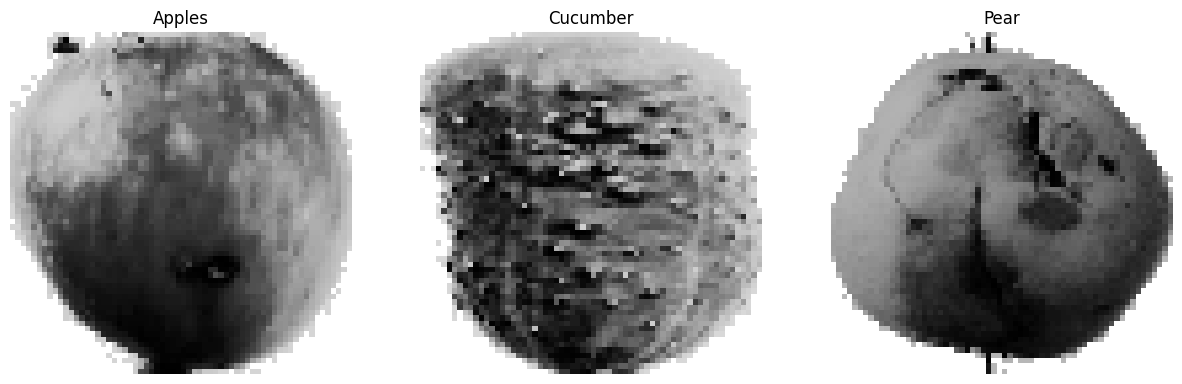

In [4]:
LABELS = {
    "Apples": 0,
    "Cucumber": 1,
    "Pear": 2
}
root_path = r"D:\projects\Project Ai KenKen\DataSetForImages"
IMG_SIZE = (64, 64)

data = []
labels = []

for fruit in os.listdir(root_path):
    fruit_path = os.path.join(root_path, fruit)

    if os.path.isdir(fruit_path):
        label = LABELS.get(fruit, None)

        for variety in os.listdir(fruit_path):
            variety_path = os.path.join(fruit_path, variety)

            print(f"Processing {fruit}/{variety}")

            for img_name in os.listdir(variety_path):
                img_path = os.path.join(variety_path, img_name)

                # Read image
                img = cv2.imread(img_path)
                # Resize image
                img = cv2.resize(img, IMG_SIZE)
                # Convert to grayscale
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # Apply histogram equalization
                img = cv2.equalizeHist(img)
                # Normalize the image
                Img_min = img.min()
                Img_max = img.max()
                img = (img - Img_min) / (Img_max - Img_min)
                
                data.append(img)
                labels.append(label)

x = np.array(data)
y = np.array(labels)
                    
fig, axes = plt.subplots(1, len(LABELS), figsize=(15,5))
for ax, (fruit, lbl) in zip(axes, LABELS.items()):
    for img, lab in zip(data, labels):
        if lab == lbl:
            ax.imshow(img, cmap='gray')
            ax.set_title(fruit)
            ax.axis('off')
            break

plt.show()


## Spliting Data

In [5]:
N, H, W,  = x.shape
X_flat = x.reshape(N, H*W)  # كل صورة تصبح vector بطول H*W

# Split to train & test
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.25, random_state=0,shuffle=True)
print(X_train.shape)
print(X_test.shape)
    

(5989, 4096)
(1997, 4096)


## Logistic Model

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(random_state=0,max_iter=1000)  
logreg.fit(X_train, y_train)


# Evaluate
y_pred = logreg.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", acc)


Logistic Regression Accuracy: 0.9734601902854282


## KMeans Clustering (Unsupervised)

In [13]:
from sklearn.cluster import KMeans

num_clusters = len(np.unique(y))  # عدد الكلاسات

kmeans = KMeans(num_clusters, n_init=300, random_state=42)

kmeans.fit(X_flat)

cluster_labels = kmeans.labels_

# توزيع الصور على clusters
for i in range(num_clusters):
    print(f"Cluster {i} has {np.sum(cluster_labels == i)} images")



Cluster 0 has 793 images
Cluster 1 has 3088 images
Cluster 2 has 4105 images


In [12]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

import numpy as np

# 1- حساب confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, cluster_labels)

# 2- إيجاد أفضل توافق بين clusters و labels

row, col = linear_sum_assignment(-cm)  # سالب لأن linear_sum_assignment تبحث عن أقل قيمة
mapping = dict(zip(col, row))

# 3- تحويل cluster labels للأرقام المقابلة للـ true labels
new_labels = np.array([mapping[label] for label in cluster_labels])

# 4- حساب accuracy
acc = accuracy_score(y, new_labels)
print("KMeans Accuracy:", acc)


KMeans Accuracy: 0.5351865765088906
